In [2]:
# Torch-related imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset

# Scikit-learn-related imports
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score

# Nibabel and Scipy imports (for handling fMRI and image processing)
import nibabel as nib
import scipy.ndimage as ndimage  # For smoothing

# NumPy, Matplotlib, and Seaborn (for data manipulation and visualization)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# OS for file system operations
import os

In [3]:
import torch
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '0'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# root_dir = os.path.join('/content/drive', 'My Drive', 'UCR', '2-2024', 'InvCC', 'ADHD200', 'Datasets', 'preprocessed')

import os
from sklearn.utils.class_weight import compute_class_weight

root_dir = os.path.join('data', 'preprocessed')

tdc_dir = os.path.join(root_dir, 'TDC')
adhd_dir = os.path.join(root_dir, 'ADHD')

# To save autoencoder state dict
save_path = os.path.join(root_dir, 'autoencoder.pt')

# Recursively find all .nii.gz files in TDC and ADHD folders
tdc_file_paths = [
    os.path.join(root, file)
    for root, _, files in os.walk(tdc_dir)
    for file in files if file.endswith('.nii.gz')
]

adhd_file_paths = [
    os.path.join(root, file)
    for root, _, files in os.walk(adhd_dir)
    for file in files if file.endswith('.nii.gz')
]

# Assuming tdc_file_paths and adhd_file_paths were correctly populated
tdc_labels = [0] * len(tdc_file_paths)  # Create labels for TDC
adhd_labels = [1] * len(adhd_file_paths)  # Create labels for ADHD

# Combine file paths and labels
file_paths = tdc_file_paths + adhd_file_paths
labels = tdc_labels + adhd_labels

# Verify lengths
print(f"Total file paths: {len(file_paths)}")  # Should be 5100
print(f"Total labels: {len(labels)}")  # Should also be 5100

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print(f'Class weights: ', class_weights)

Total file paths: 5100
Total labels: 5100
Class weights:  tensor([0.8004, 1.3323], device='cuda:0')


# Preprocessing

In [6]:
import torch
import nibabel as nib
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
from scipy import ndimage

class FMRI_Dataset(Dataset):
    def __init__(self, file_paths, labels, max_shape, smoothing_sigma=1, augment=False):
        self.file_paths = file_paths  # List of paths to the fMRI data files
        self.labels = labels  # Corresponding labels
        self.max_shape = max_shape  # Shape to pad all inputs to (e.g., [1, 61, 73, 61])
        self.smoothing_sigma = smoothing_sigma  # Standard deviation for Gaussian smoothing
        self.augment = augment  # Apply augmentations if True

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load fMRI data
        fmri_img = nib.load(self.file_paths[idx])
        data = fmri_img.get_fdata()

        # Apply Gaussian smoothing
        data = self.smooth_data(data)

        # Apply augmentations if enabled
        if self.augment:
            data = self.apply_augmentations(data)

        # Normalize the data
        data = self.normalize_data(data)

        # Convert to tensor and add missing dimensions
        data_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0)

        # Pad the tensor to the specified max_shape
        data_padded = F.pad(data_tensor, pad=self.calculate_padding(data_tensor.shape), mode='constant', value=0)

        # Ensure the final shape matches max_shape
        data_padded = data_padded.view(*self.max_shape)

        # Get the label
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return data_padded, label

    def apply_augmentations(self, data):
        data = self.add_noise(data)
        data = self.random_rotate(data)
        data = self.random_intensity_shift(data)
        return data

    def add_noise(self, data, mean=0, std=0.01):
        noise = np.random.normal(mean, std, data.shape)
        return data + noise

    def random_rotate(self, data):
        angles = np.random.uniform(-5, 5, size=3)
        return ndimage.rotate(data, angle=angles[0], axes=(1, 2), reshape=False, mode='nearest')

    def random_intensity_shift(self, data, shift_limit=0.05):
        shift_value = np.random.uniform(-shift_limit, shift_limit)
        return data + shift_value

    def calculate_padding(self, current_shape):
        padding = []
        for current_dim, max_dim in zip(reversed(current_shape), reversed(self.max_shape)):
            pad_total = max_dim - current_dim
            padding.append(pad_total // 2)
            padding.append(pad_total - (pad_total // 2))
        return padding

    def normalize_data(self, data):
        mean = data.mean()
        std = data.std()
        return (data - mean) / std if std > 0 else data

    def smooth_data(self, data):
        return ndimage.gaussian_filter(data, sigma=self.smoothing_sigma)

In [7]:
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedShuffleSplit

# Parameters
batch_size = 4
num_classes = 2
max_shape = [1, 61, 73, 61]

# Stratified Shuffle Split
labels = np.array(labels)
dataset = FMRI_Dataset(file_paths, labels, max_shape, augment=True)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)  # 70% train, 30% test

for train_index, test_index in sss.split(file_paths, labels):
    train_file_paths, test_file_paths = np.array(file_paths)[train_index], np.array(file_paths)[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]

# Further split the test set into validation and test sets
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)  # 50% of the test set for validation
for val_index, test_index in sss_val.split(test_file_paths, test_labels):
    val_file_paths, final_test_file_paths = np.array(test_file_paths)[val_index], np.array(test_file_paths)[test_index]
    val_labels, final_test_labels = test_labels[val_index], test_labels[test_index]

# Print the results
print(f"Training set size: {len(train_file_paths)}")
print(f"Validation set size: {len(val_file_paths)}")
print(f"Test set size: {len(final_test_file_paths)}")

# Create datasets
train_dataset = FMRI_Dataset(train_file_paths.tolist(), train_labels.tolist(), max_shape)
val_dataset = FMRI_Dataset(val_file_paths.tolist(), val_labels.tolist(), max_shape)
test_dataset = FMRI_Dataset(final_test_file_paths.tolist(), final_test_labels.tolist(), max_shape)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Training set size: 3570
Validation set size: 765
Test set size: 765


In [8]:
import random

# Sample based on actual length
sample_size = min(4, len(file_paths))
sample_indices = random.sample(range(len(file_paths)), sample_size)

for idx in sample_indices:
    print(f"File Path: {file_paths[idx]}")
    print(f"Label: {labels[idx]}")
    data = nib.load(file_paths[idx]).get_fdata()
    print(f"Data Shape: {data.shape}\n")


File Path: data/preprocessed/ADHD/ADHD200_DPARSF_ADHD200_NYU_8915162_ADHD/ReHoMap_ADHD200_NYU_8915162.nii.gz
Label: 1
Data Shape: (61, 73, 61)

File Path: data/preprocessed/TDC/ADHD200_DPARSF_ADHD200_WashU_0015002_HC/fALFFMap_ADHD200_WashU_0015002.nii.gz
Label: 0
Data Shape: (61, 73, 61)

File Path: data/preprocessed/TDC/ADHD200_DPARSF_ADHD200_Pittsburgh_0016020_HC/fALFFMap_ADHD200_Pittsburgh_0016020.nii.gz
Label: 0
Data Shape: (61, 73, 61)

File Path: data/preprocessed/TDC/ADHD200_DPARSF_ADHD200_Peking_1_2703336_HC/DegreeCentrality_PositiveWeightedSumBrainMap_ADHD200_Peking_1_2703336.nii.gz
Label: 0
Data Shape: (61, 73, 61)



# CNN-AE

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNN_Autoencoder(nn.Module):
    def __init__(self):
        super(CNN_Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.Conv3d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.Conv3d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(512),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=(1, 1, 1)),
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.ConvTranspose3d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=(1, 0, 1)),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.ConvTranspose3d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(0, 0, 0)),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.ConvTranspose3d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=(0, 0, 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = CNN_Autoencoder().to(device)

# Generate random input
inputs = torch.rand((4, 1, 61, 73, 61)).to(device)  # Example input shape
output = autoencoder(inputs)
print(output.shape)  # Should match the input shape [4, 1, 61, 73, 61]

# Loss and optimizer
from torch.optim.lr_scheduler import StepLR

criterion = nn.MSELoss()  # Mean Squared Error for autoencoder
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00001, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce LR by a factor of 0.1 every 10 epochs

torch.Size([4, 1, 61, 73, 61])


# CNN

### Using pretrained weights

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNOnEncoder(nn.Module):
    def __init__(self, autoencoder, num_classes):
        super(CNNOnEncoder, self).__init__()
        self.encoder = autoencoder.encoder  # Use the encoder from the autoencoder
        
        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv3d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(256)  # Batch norm after conv1
        
        self.conv2 = nn.Conv3d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(128)  # Batch norm after conv2
        
        self.conv3 = nn.Conv3d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm3d(64)  # Batch norm after conv3
        
        # Pooling and fully connected layers
        self.pool = nn.AdaptiveMaxPool3d(output_size=(10, 10, 10))
        self.fc1 = nn.Linear(64 * 10 * 10 * 10, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.encoder(x)  # Encoder from autoencoder

        # Convolutional layers with batch normalization and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Output layer, without softmax
        
        return x

In [28]:
from torch.optim.lr_scheduler import StepLR

# Load trained autoencoder
trained_autoencoder = CNN_Autoencoder()
trained_autoencoder.load_state_dict(torch.load(save_path, weights_only=True))
trained_autoencoder.to(device)
trained_autoencoder.eval() # Set the model to evaluation mode

# Create an instance of the new model
cnn_with_ae_model = CNNOnEncoder(trained_autoencoder, num_classes=2).to(device)

# Optionally, freeze the encoder layers, Frozen= false, Unfrozen= true
for param in cnn_with_ae_model.encoder.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(cnn_with_ae_model.parameters(), lr=0.00001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce LR by a factor of 0.1 every 10 epochs

In [29]:
num_epochs = 50
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    cnn_with_ae_model.train()
    total_loss = 0.0
    all_labels = []
    all_preds = []

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = cnn_with_ae_model(inputs)

        loss = criterion(output, labels)

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate the loss
        total_loss += loss.item()

        # Store predictions and labels for accuracy calculation
        _, preds = torch.max(output, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Calculate training accuracy and average loss for the epoch
    train_accuracy = accuracy_score(all_labels, all_preds)
    avg_train_loss = total_loss / len(train_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Validation phase
    cnn_with_ae_model.eval()
    val_loss = 0.0
    val_labels = []
    val_preds = []

    with torch.no_grad():
        for val_inputs, val_labels_batch in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels_batch = val_labels_batch.to(device)

            # Forward pass for validation data
            val_outputs = cnn_with_ae_model(val_inputs)
            loss = criterion(val_outputs, val_labels_batch)
            val_loss += loss.item()

            # Store predictions and labels for accuracy calculation
            _, val_preds_batch = torch.max(val_outputs, 1)
            val_labels.extend(val_labels_batch.cpu().numpy())
            val_preds.extend(val_preds_batch.cpu().numpy())

    # Calculate validation accuracy and average loss
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(cnn_with_ae_model.state_dict(), 'best_cnn_with_ae.pt')
        print(f'Model saved at epoch {epoch+1} with validation loss: {avg_val_loss:.4f}')

    # Save the model after each epoch
    torch.save(cnn_with_ae_model.state_dict(), f'cnn_with_ae_epoch{epoch+1}.pt')

    scheduler.step()

# Save the final trained model
torch.save(cnn_with_ae_model.state_dict(), 'cnn_with_ae_final.pt')

Epoch [1/50], Train Loss: 0.6770, Train Accuracy: 0.6244
Epoch [1/50], Val Loss: 0.6334, Val Accuracy: 0.6627
Model saved at epoch 1 with validation loss: 0.6334
Epoch [2/50], Train Loss: 0.6438, Train Accuracy: 0.6294
Epoch [2/50], Val Loss: 0.6347, Val Accuracy: 0.5595
Epoch [3/50], Train Loss: 0.6150, Train Accuracy: 0.6482
Epoch [3/50], Val Loss: 0.6158, Val Accuracy: 0.6379
Model saved at epoch 3 with validation loss: 0.6158
Epoch [4/50], Train Loss: 0.5586, Train Accuracy: 0.6966
Epoch [4/50], Val Loss: 0.5321, Val Accuracy: 0.7150
Model saved at epoch 4 with validation loss: 0.5321
Epoch [5/50], Train Loss: 0.4622, Train Accuracy: 0.7616
Epoch [5/50], Val Loss: 0.4733, Val Accuracy: 0.7438
Model saved at epoch 5 with validation loss: 0.4733
Epoch [6/50], Train Loss: 0.3466, Train Accuracy: 0.8134
Epoch [6/50], Val Loss: 0.5149, Val Accuracy: 0.7647
Epoch [7/50], Train Loss: 0.2886, Train Accuracy: 0.8412
Epoch [7/50], Val Loss: 0.6825, Val Accuracy: 0.7725
Epoch [8/50], Train Lo

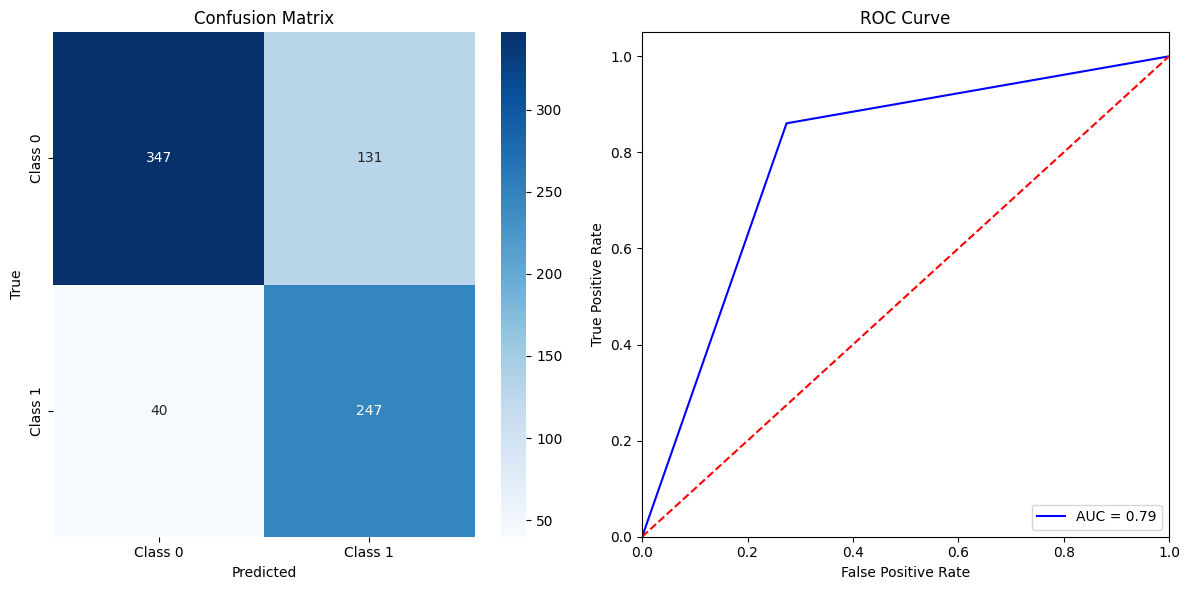

Accuracy of the CNN with autoencoder on the test images: 77.65%
Average loss on the test images: 0.8538
Sensitivity (Recall): 0.86
Specificity: 0.73
AUC: 0.79


In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Testing loop

# Load trained autoencoder
trained_autoencoder = CNN_Autoencoder()
trained_autoencoder.load_state_dict(torch.load(save_path, weights_only=True))
trained_autoencoder.to(device)
trained_autoencoder.eval() # Set the model to evaluation mode

# Load the model
num_classes = 2

classifier_model = CNNOnEncoder(trained_autoencoder, num_classes=2).to(device)  # Initialize your classifier model
model_state_dict = torch.load('cnn_with_ae/cnn_with_ae_final.pt', weights_only=False)
classifier_model.load_state_dict(model_state_dict)

# Set the model to evaluation mode
classifier_model.eval()

# Define criterion (loss function)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Test the model
correct = 0
total = 0
total_loss = 0.0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        output = classifier_model(inputs)
        loss = criterion(output, labels)
        
        total_loss += loss.item()
        
        # Get predictions and probabilities
        _, predicted = torch.max(output, 1)
        
        # Update counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store predictions, labels, and probabilities for further metrics
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate accuracy and average loss
accuracy = 100 * correct / total
average_loss = total_loss / len(test_loader)

# Calculate confusion matrix and derived metrics
conf_matrix = confusion_matrix(all_labels, all_preds)
TN, FP, FN, TP = conf_matrix.ravel()
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensitivity / Recall
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Specificity

# Calculate AUC and plot ROC curve
auc_score = roc_auc_score(all_labels, all_preds)
fpr, tpr, _ = roc_curve(all_labels, all_preds)

# Plot confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Confusion matrix plot
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax[0],
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')
ax[0].set_title('Confusion Matrix')

# ROC curve plot
ax[1].plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
ax[1].plot([0, 1], [0, 1], 'r--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

# Print metrics
print(f'Accuracy of the CNN with autoencoder on the test images: {accuracy:.2f}%')
print(f'Average loss on the test images: {average_loss:.4f}')
print(f'Sensitivity (Recall): {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'AUC: {auc_score:.2f}')

### Not using pretrained weights

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(64)  # Added BatchNorm layer
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(128)  # Added BatchNorm layer
        self.conv3 = nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm3d(256)  # Added BatchNorm layer

        self.pool = nn.AdaptiveMaxPool3d(output_size=(10, 10, 10))
        self.fc1 = nn.Linear(256 * 10 * 10 * 10, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [9]:
from torch.optim.lr_scheduler import StepLR


simple_cnn_model = SimpleCNN(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(simple_cnn_model.parameters(), lr=0.00001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce LR by a factor of 0.1 every 10 epochs

example_input = torch.randn(4, 1, 61, 73, 61)
example_output = simple_cnn_model(example_input.to(device))
print("Output shape:", example_output.shape)

Output shape: torch.Size([4, 2])


In [10]:
# Training loop

num_epochs = 50
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    simple_cnn_model.train()
    total_loss = 0.0
    all_labels = []
    all_preds = []

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = simple_cnn_model(inputs)

        loss = criterion(output, labels)

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate the loss
        total_loss += loss.item()

        # Store predictions and labels for accuracy calculation
        _, preds = torch.max(output, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Calculate training accuracy and average loss for the epoch
    train_accuracy = accuracy_score(all_labels, all_preds)
    avg_train_loss = total_loss / len(train_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Validation phase
    simple_cnn_model.eval()
    val_loss = 0.0
    val_labels = []
    val_preds = []

    with torch.no_grad():
        for val_inputs, val_labels_batch in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels_batch = val_labels_batch.to(device)

            # Forward pass for validation data
            val_outputs = simple_cnn_model(val_inputs)
            loss = criterion(val_outputs, val_labels_batch)
            val_loss += loss.item()

            # Store predictions and labels for accuracy calculation
            _, val_preds_batch = torch.max(val_outputs, 1)
            val_labels.extend(val_labels_batch.cpu().numpy())
            val_preds.extend(val_preds_batch.cpu().numpy())

    # Calculate validation accuracy and average loss
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)


    print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(simple_cnn_model.state_dict(), 'best_simple_cnn.pt')
        print(f'Model saved at epoch {epoch+1} with validation loss: {avg_val_loss:.4f}')

    # Save the model after each epoch
    torch.save(simple_cnn_model.state_dict(), f'simple_cnn_epoch{epoch+1}.pt')

    scheduler.step()

# Save the final trained model
torch.save(simple_cnn_model.state_dict(), 'simple_cnn_final.pt')

Epoch [1/50], Train Loss: 0.7207, Train Accuracy: 0.5950
Epoch [1/50], Val Loss: 0.6582, Val Accuracy: 0.6627
Model saved at epoch 1 with validation loss: 0.6582
Epoch [2/50], Train Loss: 0.6640, Train Accuracy: 0.6112
Epoch [2/50], Val Loss: 0.6355, Val Accuracy: 0.6627
Model saved at epoch 2 with validation loss: 0.6355
Epoch [3/50], Train Loss: 0.6478, Train Accuracy: 0.6185
Epoch [3/50], Val Loss: 0.6333, Val Accuracy: 0.6510
Model saved at epoch 3 with validation loss: 0.6333
Epoch [4/50], Train Loss: 0.6355, Train Accuracy: 0.6174
Epoch [4/50], Val Loss: 0.6227, Val Accuracy: 0.6627
Model saved at epoch 4 with validation loss: 0.6227
Epoch [5/50], Train Loss: 0.6316, Train Accuracy: 0.6392
Epoch [5/50], Val Loss: 0.6114, Val Accuracy: 0.6693
Model saved at epoch 5 with validation loss: 0.6114
Epoch [6/50], Train Loss: 0.6233, Train Accuracy: 0.6409
Epoch [6/50], Val Loss: 0.6136, Val Accuracy: 0.6706
Epoch [7/50], Train Loss: 0.6120, Train Accuracy: 0.6630
Epoch [7/50], Val Loss:

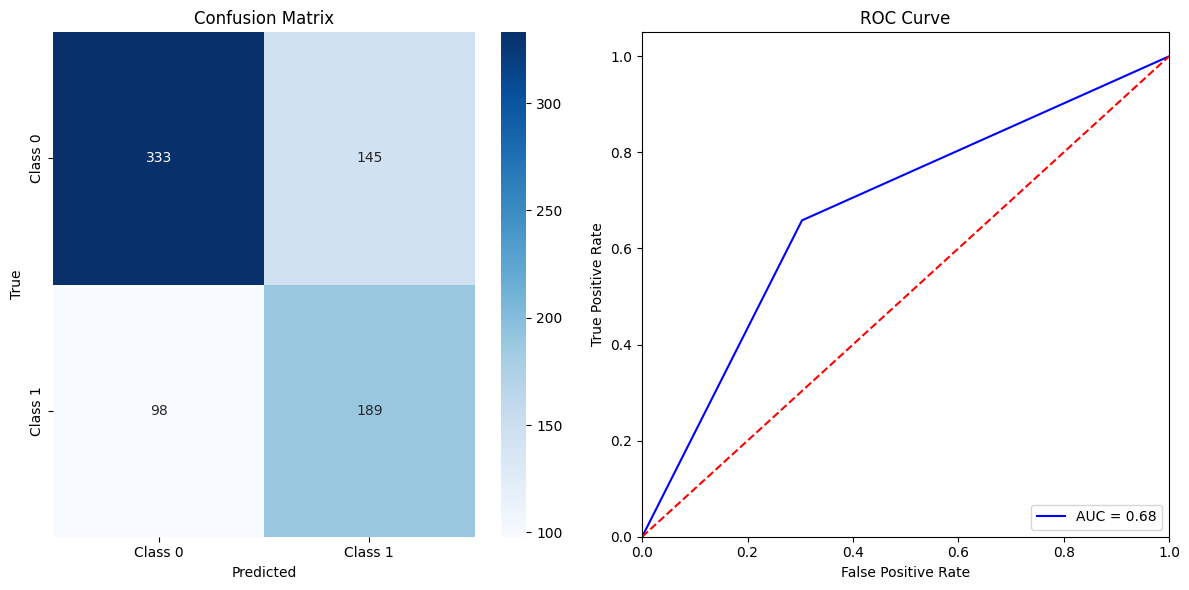

Accuracy of the simple CNN on the test images: 68.24%
Average loss on the test images: 0.5847
Sensitivity (Recall): 0.66
Specificity: 0.70
AUC: 0.68


In [11]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the model
classifier_model = SimpleCNN(num_classes=2).to(device)  # Initialize your classifier model
model_state_dict = torch.load('simple_cnn_final.pt', weights_only=False)
classifier_model.load_state_dict(model_state_dict)

# Set the model to evaluation mode
classifier_model.eval()

# Define criterion (loss function)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Test the model
correct = 0
total = 0
total_loss = 0.0
all_labels = []
all_preds = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        output = classifier_model(inputs)
        loss = criterion(output, labels)
        
        total_loss += loss.item()
        
        # Get predictions and probabilities
        _, predicted = torch.max(output, 1)
        
        # Update counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store predictions, labels, and probabilities for further metrics
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate accuracy and average loss
accuracy = 100 * correct / total
average_loss = total_loss / len(test_loader)

# Calculate confusion matrix and derived metrics
conf_matrix = confusion_matrix(all_labels, all_preds)
TN, FP, FN, TP = conf_matrix.ravel()
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensitivity / Recall
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Specificity

# Calculate AUC and plot ROC curve
auc_score = roc_auc_score(all_labels, all_preds)
fpr, tpr, _ = roc_curve(all_labels, all_preds)

# Plot confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Confusion matrix plot
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax[0],
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')
ax[0].set_title('Confusion Matrix')

# ROC curve plot
ax[1].plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
ax[1].plot([0, 1], [0, 1], 'r--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

# Print metrics
print(f'Accuracy of the simple CNN on the test images: {accuracy:.2f}%')
print(f'Average loss on the test images: {average_loss:.4f}')
print(f'Sensitivity (Recall): {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'AUC: {auc_score:.2f}')

# CNN-LSTM

### Using pretrained weights

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNLSTMOnAutoencoder(nn.Module):
    def __init__(self, autoencoder, hidden_size=64, num_classes=2):
        super(CNNLSTMOnAutoencoder, self).__init__()
        
        # Use the encoder from the pre-trained autoencoder
        self.encoder = autoencoder.encoder
        
        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv3d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(256)
        
        self.conv2 = nn.Conv3d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(128)

        self.conv3 = nn.Conv3d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm3d(64)
        
        # Adaptive max pooling layer
        self.pool = nn.AdaptiveMaxPool3d(output_size=(10, 10, 60))
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=64 * 10 * 10, hidden_size=hidden_size, num_layers=2, dropout=0.5, batch_first=True, bidirectional=True)

        # Fully connected layer
        self.fc1 = nn.Linear(hidden_size * 2, 256)  # Adjust the input size based on the pooled output
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)  

    def forward(self, x):
        batch_size = x.size(0)

        # Pass through the encoder
        x = self.encoder(x)

        # Convolutional layers with batch normalization and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Get the output shape after convolutions
        batch_size, channels, new_height, new_width, new_depth = x.shape
        lstm_input_size = channels * new_height * new_width

        # Reshape for LSTM input (sequence length is new_depth)
        x = x.view(batch_size, new_depth, lstm_input_size)

        # Pass through the LSTM layer
        lstm_out, _ = self.lstm(x)

        # Take the last time step output for further processing
        out = lstm_out[:, -1, :]

        # Pass through the fully connected layers
        out = F.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out


In [30]:
from torch.optim.lr_scheduler import StepLR

# Load trained autoencoder
trained_autoencoder = CNN_Autoencoder().to(device)
trained_autoencoder.load_state_dict(torch.load(save_path, weights_only=True))
trained_autoencoder.eval() # Set the model to evaluation mode

# Model with pretrained weights
cnn_lstm_with_ae = CNNLSTMOnAutoencoder(trained_autoencoder, hidden_size=64, num_classes=2).to(device)

# Optionally, freeze the encoder layers, Frozen= false, Unfrozen= true
for param in cnn_lstm_with_ae.encoder.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(cnn_lstm_with_ae.parameters(), lr=0.00001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce LR by a factor of 0.1 every 10 epochs

In [31]:
# Training loop

num_epochs = 50
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    cnn_lstm_with_ae.train()
    total_loss = 0.0
    all_labels = []
    all_preds = []

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = cnn_lstm_with_ae(inputs)

        loss = criterion(output, labels)

        # Backward pass
        loss.backward()

        # Avoiding exploiting or vanishing gradients
        nn.utils.clip_grad_norm_(cnn_lstm_with_ae.parameters(), max_norm=1.0)

        # Update model parameters
        optimizer.step()

        # Accumulate the loss
        total_loss += loss.item()

        # Store predictions and labels for accuracy calculation
        _, preds = torch.max(output, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Calculate training accuracy and average loss for the epoch
    train_accuracy = accuracy_score(all_labels, all_preds)
    avg_train_loss = total_loss / len(train_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Validation phase
    cnn_lstm_with_ae.eval()
    val_loss = 0.0
    val_labels = []
    val_preds = []

    with torch.no_grad():
        for val_inputs, val_labels_batch in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels_batch = val_labels_batch.to(device)

            # Forward pass for validation data
            val_outputs = cnn_lstm_with_ae(val_inputs)
            loss = criterion(val_outputs, val_labels_batch)
            val_loss += loss.item()

            # Store predictions and labels for accuracy calculation
            _, val_preds_batch = torch.max(val_outputs, 1)
            val_labels.extend(val_labels_batch.cpu().numpy())
            val_preds.extend(val_preds_batch.cpu().numpy())

    # Calculate validation accuracy and average loss
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(cnn_lstm_with_ae.state_dict(), 'best_cnnlstm_with_ae.pt')
        print(f'Model saved at epoch {epoch+1} with validation loss: {avg_val_loss:.4f}')

    # Save the model after each epoch
    torch.save(cnn_lstm_with_ae.state_dict(), f'cnnlstm_with_ae_epoch{epoch+1}.pt')

    scheduler.step()

# Save the final trained model
torch.save(cnn_lstm_with_ae.state_dict(), 'cnnlstm_with_ae_final.pt')


Epoch [1/50], Train Loss: 0.6756, Train Accuracy: 0.6515
Epoch [1/50], Val Loss: 0.6600, Val Accuracy: 0.6627
Model saved at epoch 1 with validation loss: 0.6600
Epoch [2/50], Train Loss: 0.6611, Train Accuracy: 0.6633
Epoch [2/50], Val Loss: 0.6552, Val Accuracy: 0.6627
Model saved at epoch 2 with validation loss: 0.6552
Epoch [3/50], Train Loss: 0.6603, Train Accuracy: 0.6636
Epoch [3/50], Val Loss: 0.6558, Val Accuracy: 0.6627
Epoch [4/50], Train Loss: 0.6602, Train Accuracy: 0.6633
Epoch [4/50], Val Loss: 0.6578, Val Accuracy: 0.6627
Epoch [5/50], Train Loss: 0.6566, Train Accuracy: 0.6636
Epoch [5/50], Val Loss: 0.6555, Val Accuracy: 0.6627
Epoch [6/50], Train Loss: 0.6558, Train Accuracy: 0.6622
Epoch [6/50], Val Loss: 0.6417, Val Accuracy: 0.6641
Model saved at epoch 6 with validation loss: 0.6417
Epoch [7/50], Train Loss: 0.6319, Train Accuracy: 0.6653
Epoch [7/50], Val Loss: 0.6369, Val Accuracy: 0.6784
Model saved at epoch 7 with validation loss: 0.6369
Epoch [8/50], Train Lo

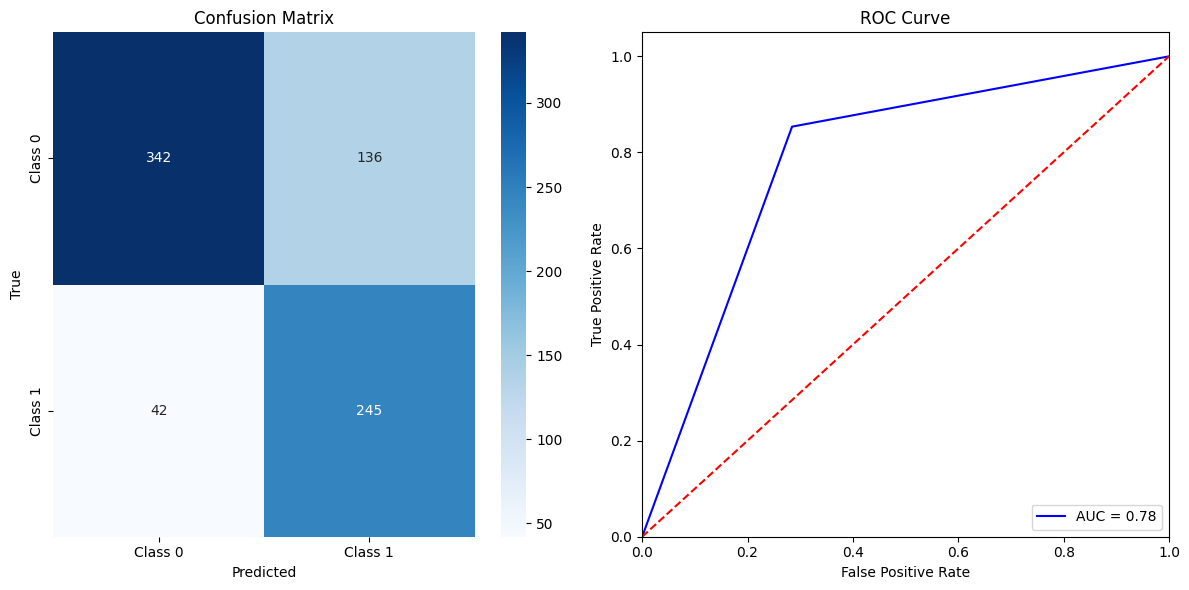

Accuracy of the CNN-LSTM with autoencoder on the test images: 76.73%
Average loss on the test images: 0.6218
Sensitivity (Recall): 0.85
Specificity: 0.72
AUC: 0.78


In [32]:
# Testing loop
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load trained autoencoder
trained_autoencoder = CNN_Autoencoder().to(device)
trained_autoencoder.load_state_dict(torch.load(save_path, weights_only=True))
trained_autoencoder.eval() # Set the model to evaluation mode

# Load the model
classifier_model = CNNLSTMOnAutoencoder(trained_autoencoder, hidden_size=64, num_classes=2).to(device)  # Initialize your classifier model
model_state_dict = torch.load('cnnlstm_with_ae_final.pt', weights_only=False)
classifier_model.load_state_dict(model_state_dict)

# Set the model to evaluation mode
classifier_model.eval()

# Define criterion (loss function)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Test the model
correct = 0
total = 0
total_loss = 0.0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        output = classifier_model(inputs)
        loss = criterion(output, labels)
        
        total_loss += loss.item()
        
        # Get predictions and probabilities
        _, predicted = torch.max(output, 1)
        
        # Update counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store predictions, labels, and probabilities for further metrics
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate accuracy and average loss
accuracy = 100 * correct / total
average_loss = total_loss / len(test_loader)

# Calculate confusion matrix and derived metrics
conf_matrix = confusion_matrix(all_labels, all_preds)
TN, FP, FN, TP = conf_matrix.ravel()
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensitivity / Recall
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Specificity

# Calculate AUC and plot ROC curve
auc_score = roc_auc_score(all_labels, all_preds)
fpr, tpr, _ = roc_curve(all_labels, all_preds)

# Plot confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Confusion matrix plot
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax[0],
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')
ax[0].set_title('Confusion Matrix')

# ROC curve plot
ax[1].plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
ax[1].plot([0, 1], [0, 1], 'r--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

# Print metrics
print(f'Accuracy of the CNN-LSTM with autoencoder on the test images: {accuracy:.2f}%')
print(f'Average loss on the test images: {average_loss:.4f}')
print(f'Sensitivity (Recall): {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'AUC: {auc_score:.2f}')

### Not using pretrained weights

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNNLSTM(nn.Module):
    def __init__(self, hidden_size=64, num_classes=2):
        super(SimpleCNNLSTM, self).__init__()
        
        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(64)
        
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(128)

        self.conv3 = nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm3d(256)

        # Adaptive max pooling layer
        self.pool = nn.AdaptiveMaxPool3d(output_size=(10, 10, 60))
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=256 * 10 * 10, hidden_size=hidden_size, num_layers=2, dropout=0.5, batch_first=True, bidirectional=True)

        # Fully connected layer
        self.fc1 = nn.Linear(hidden_size * 2, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)  

    def forward(self, x):
        batch_size = x.size(0)

        # Convolutional layers with batch normalization and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Get the output shape after convolutions
        batch_size, channels, new_height, new_width, new_depth = x.shape
        lstm_input_size = channels * new_height * new_width

        # Reshape for LSTM input (sequence length is new_depth)
        x = x.view(batch_size, new_depth, lstm_input_size)

        # Pass through the LSTM layer
        lstm_out, _ = self.lstm(x)

        # Take the output from the last LSTM step
        out = lstm_out[:, -1, :]

        # Pass through the fully connected layer
        out = F.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

In [34]:
from torch.optim.lr_scheduler import StepLR

# Model without pretrained weights
simple_cnnlstm = SimpleCNNLSTM(hidden_size=64, num_classes=2).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(simple_cnnlstm.parameters(), lr=0.00001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce LR by a factor of 0.1 every 10 epochs

In [35]:
# Training loop

num_epochs = 50
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    simple_cnnlstm.train()
    total_loss = 0.0
    all_labels = []
    all_preds = []

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = simple_cnnlstm(inputs)

        loss = criterion(output, labels)

        # Backward pass
        loss.backward()

        # Avoiding exploiting or vanishing gradients
        nn.utils.clip_grad_norm_(simple_cnnlstm.parameters(), max_norm=1.0)

        # Update model parameters
        optimizer.step()

        # Accumulate the loss
        total_loss += loss.item()

        # Store predictions and labels for accuracy calculation
        _, preds = torch.max(output, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Calculate training accuracy and average loss for the epoch
    train_accuracy = accuracy_score(all_labels, all_preds)
    avg_train_loss = total_loss / len(train_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Validation phase
    simple_cnnlstm.eval()
    val_loss = 0.0
    val_labels = []
    val_preds = []

    with torch.no_grad():
        for val_inputs, val_labels_batch in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels_batch = val_labels_batch.to(device)

            # Forward pass for validation data
            val_outputs = simple_cnnlstm(val_inputs)
            loss = criterion(val_outputs, val_labels_batch)
            val_loss += loss.item()

            # Store predictions and labels for accuracy calculation
            _, val_preds_batch = torch.max(val_outputs, 1)
            val_labels.extend(val_labels_batch.cpu().numpy())
            val_preds.extend(val_preds_batch.cpu().numpy())

    # Calculate validation accuracy and average loss
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(simple_cnnlstm.state_dict(), 'best_simple_cnnlstm.pt')
        print(f'Model saved at epoch {epoch+1} with validation loss: {avg_val_loss:.4f}')

    # Save the model after each epoch
    torch.save(simple_cnnlstm.state_dict(), f'simple_cnnlstm_epoch{epoch+1}.pt')

    scheduler.step()

# Save the final trained model
torch.save(simple_cnnlstm.state_dict(), 'simple_cnnlstm_final.pt')

Epoch [1/50], Train Loss: 0.6778, Train Accuracy: 0.6157
Epoch [1/50], Val Loss: 0.6593, Val Accuracy: 0.6627
Model saved at epoch 1 with validation loss: 0.6593
Epoch [2/50], Train Loss: 0.6632, Train Accuracy: 0.6630
Epoch [2/50], Val Loss: 0.6536, Val Accuracy: 0.6627
Model saved at epoch 2 with validation loss: 0.6536
Epoch [3/50], Train Loss: 0.6580, Train Accuracy: 0.6636
Epoch [3/50], Val Loss: 0.6604, Val Accuracy: 0.6627
Epoch [4/50], Train Loss: 0.6599, Train Accuracy: 0.6636
Epoch [4/50], Val Loss: 0.6606, Val Accuracy: 0.6627
Epoch [5/50], Train Loss: 0.6591, Train Accuracy: 0.6636
Epoch [5/50], Val Loss: 0.6662, Val Accuracy: 0.6627
Epoch [6/50], Train Loss: 0.6626, Train Accuracy: 0.6636
Epoch [6/50], Val Loss: 0.6580, Val Accuracy: 0.6627
Epoch [7/50], Train Loss: 0.6609, Train Accuracy: 0.6636
Epoch [7/50], Val Loss: 0.6536, Val Accuracy: 0.6627
Model saved at epoch 7 with validation loss: 0.6536
Epoch [8/50], Train Loss: 0.6568, Train Accuracy: 0.6636
Epoch [8/50], Val

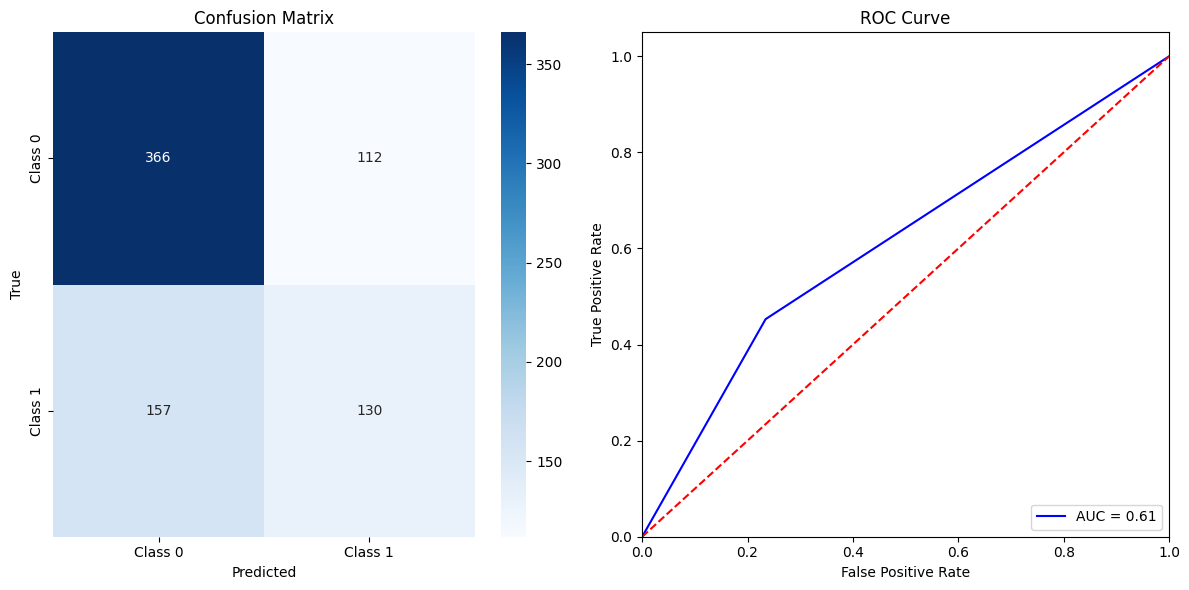

Accuracy of the simple CNN-LSTM on the test images: 64.84%
Average loss on the test images: 0.6671
Sensitivity (Recall): 0.45
Specificity: 0.77
AUC: 0.61


In [11]:
# Testing loop
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the model
classifier_model = SimpleCNNLSTM(hidden_size=64, num_classes=2).to(device)  # Initialize your classifier model
model_state_dict = torch.load('simple_cnnlstm_final.pt', weights_only=False)
classifier_model.load_state_dict(model_state_dict)

# Set the model to evaluation mode
classifier_model.eval()

# Define criterion (loss function)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Test the model
correct = 0
total = 0
total_loss = 0.0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        output = classifier_model(inputs)
        loss = criterion(output, labels)
        
        total_loss += loss.item()
        
        # Get predictions and probabilities
        _, predicted = torch.max(output, 1)
        
        # Update counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store predictions, labels, and probabilities for further metrics
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate accuracy and average loss
accuracy = 100 * correct / total
average_loss = total_loss / len(test_loader)

# Calculate confusion matrix and derived metrics
conf_matrix = confusion_matrix(all_labels, all_preds)
TN, FP, FN, TP = conf_matrix.ravel()
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensitivity / Recall
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Specificity

# Calculate AUC and plot ROC curve
auc_score = roc_auc_score(all_labels, all_preds)
fpr, tpr, _ = roc_curve(all_labels, all_preds)

# Plot confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Confusion matrix plot
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax[0],
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')
ax[0].set_title('Confusion Matrix')

# ROC curve plot
ax[1].plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
ax[1].plot([0, 1], [0, 1], 'r--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

# Print metrics
print(f'Accuracy of the simple CNN-LSTM on the test images: {accuracy:.2f}%')
print(f'Average loss on the test images: {average_loss:.4f}')
print(f'Sensitivity (Recall): {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'AUC: {auc_score:.2f}')

# Graphs

Accuracy of the CNN with AE on the test images: 74.38%
Average loss on the test images: 0.5154
Sensitivity (Recall): 0.74
Specificity: 0.75
AUC: 0.74
Accuracy of the Pure CNN on the test images: 68.24%
Average loss on the test images: 0.5847
Sensitivity (Recall): 0.66
Specificity: 0.70
AUC: 0.68
Accuracy of the CNN-LSTM with AE on the test images: 76.73%
Average loss on the test images: 0.6218
Sensitivity (Recall): 0.85
Specificity: 0.72
AUC: 0.78
Accuracy of the Pure CNN-LSTM on the test images: 64.84%
Average loss on the test images: 0.6671
Sensitivity (Recall): 0.45
Specificity: 0.77
AUC: 0.61


<Figure size 800x600 with 0 Axes>

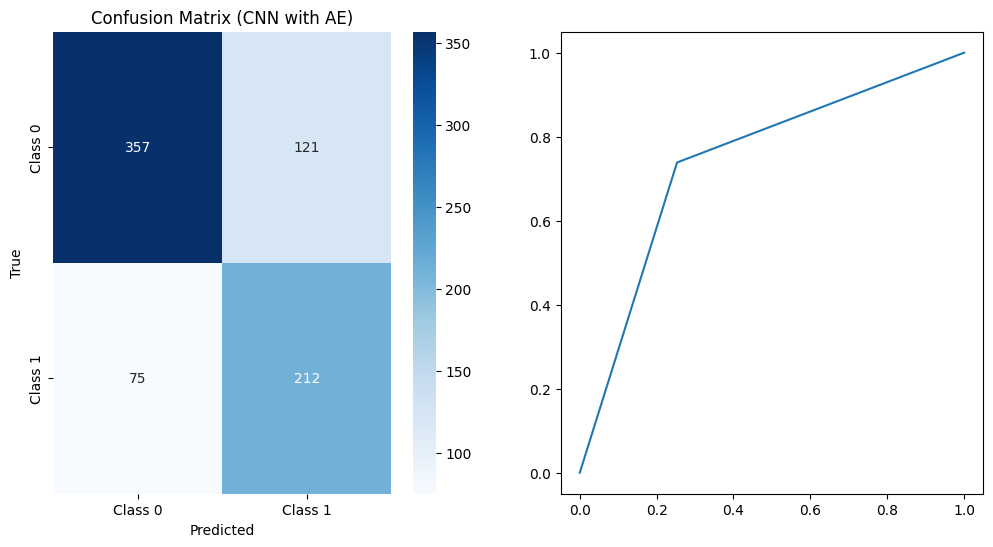

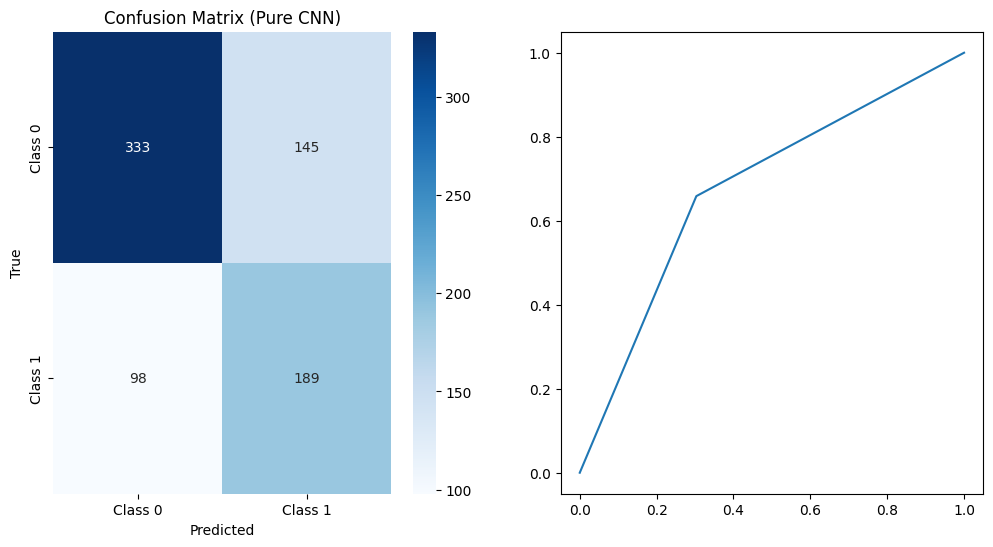

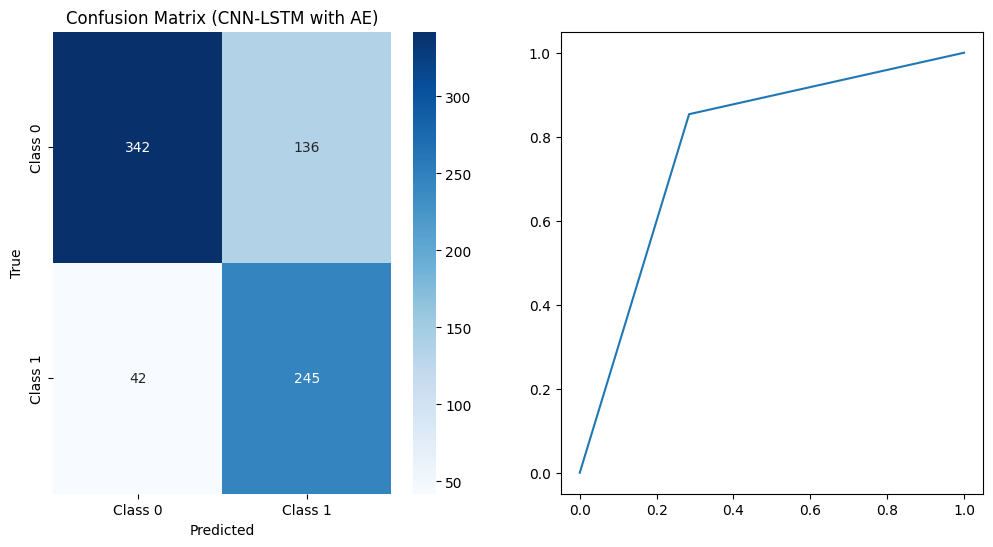

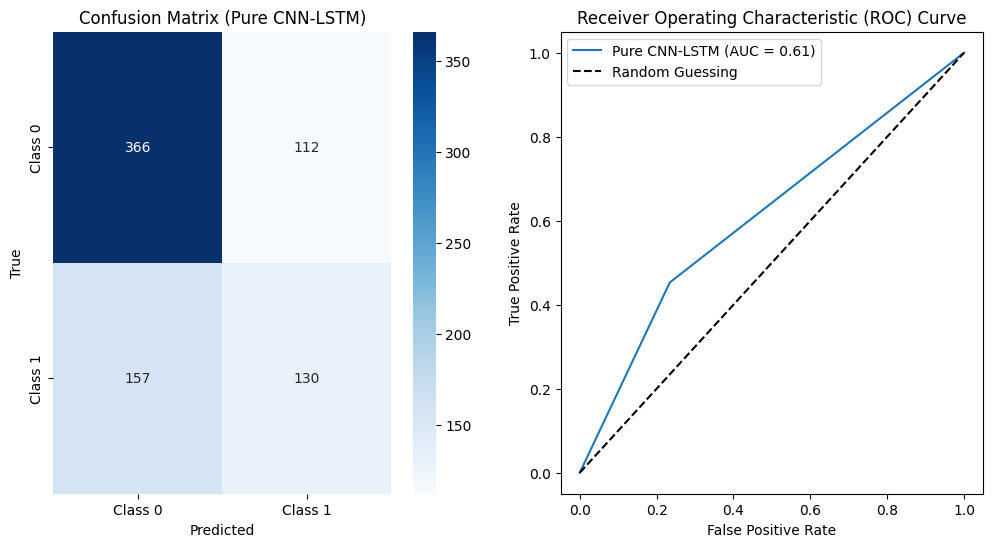

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Initialize models
trained_autoencoder = CNN_Autoencoder()
trained_autoencoder.load_state_dict(torch.load(save_path, weights_only=True))
trained_autoencoder.to(device)
trained_autoencoder.eval() # Set the model to evaluation mode

# Load the model
num_classes = 2

# CNN with AE
cnn_ae = CNNOnEncoder(trained_autoencoder, num_classes=num_classes).to(device)  # Initialize your classifier model
cnn_ae_model_state_dict = torch.load('cnn_with_ae_final.pt', weights_only=False)
cnn_ae.load_state_dict(cnn_ae_model_state_dict)
cnn_ae.eval()

# Pure CNN
simple_cnn = SimpleCNN(num_classes=num_classes).to(device)  # Initialize your classifier model
simple_cnn_model_state_dict = torch.load('simple_cnn_final.pt', weights_only=False)
simple_cnn.load_state_dict(simple_cnn_model_state_dict)
simple_cnn.eval()

# CNN-LSTM with AE
cnnlstm_ae = CNNLSTMOnAutoencoder(trained_autoencoder, num_classes=num_classes).to(device)  # Initialize your classifier model
cnnlstm_ae_model_state_dict = torch.load('cnnlstm_with_ae_final.pt', weights_only=False)
cnnlstm_ae.load_state_dict(cnnlstm_ae_model_state_dict)
cnnlstm_ae.eval()

# Pure CNN-LSTM
simple_cnnlstm = SimpleCNNLSTM(num_classes=num_classes).to(device)  # Initialize your classifier model
simple_cnnlstm_model_state_dict = torch.load('simple_cnnlstm_final.pt', weights_only=False)
simple_cnnlstm.load_state_dict(simple_cnnlstm_model_state_dict)
simple_cnnlstm.eval()

# Define criterion (loss function)
criterion = nn.CrossEntropyLoss(weight=class_weights)

models = {
    "CNN with AE": cnn_ae,
    "Pure CNN": simple_cnn,
    "CNN-LSTM with AE": cnnlstm_ae,
    "Pure CNN-LSTM": simple_cnnlstm,
}

# Plot ROC curves
plt.figure(figsize=(8, 6))
for model_name, model in models.items():
    # Test the model
    correct = 0
    total = 0
    total_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Send inputs and labels to the device (GPU if available)
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            output = model(inputs)
            loss = criterion(output, labels)
            
            total_loss += loss.item()
            
            # Get predictions and probabilities
            _, predicted = torch.max(output, 1)
            
            # Update counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store predictions, labels, and probabilities for further metrics
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate accuracy and average loss
    accuracy = 100 * correct / total
    average_loss = total_loss / len(test_loader)

    # Calculate confusion matrix and derived metrics
    conf_matrix = confusion_matrix(all_labels, all_preds)
    TN, FP, FN, TP = conf_matrix.ravel()
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensitivity / Recall
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Specificity

    # Plot confusion matrix
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Confusion matrix plot
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax[0],
                xticklabels=[f'Class {i}' for i in range(num_classes)],
                yticklabels=[f'Class {i}' for i in range(num_classes)])
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('True')
    ax[0].set_title(f'Confusion Matrix ({model_name})')

    # Calculate AUC and plot ROC curve
    auc_score = roc_auc_score(all_labels, all_preds)
    fpr, tpr, _ = roc_curve(all_labels, all_preds)

    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

    # Print metrics
    print(f'Accuracy of the {model_name} on the test images: {accuracy:.2f}%')
    print(f'Average loss on the test images: {average_loss:.4f}')
    print(f'Sensitivity (Recall): {sensitivity:.2f}')
    print(f'Specificity: {specificity:.2f}')
    print(f'AUC: {auc_score:.2f}')

plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

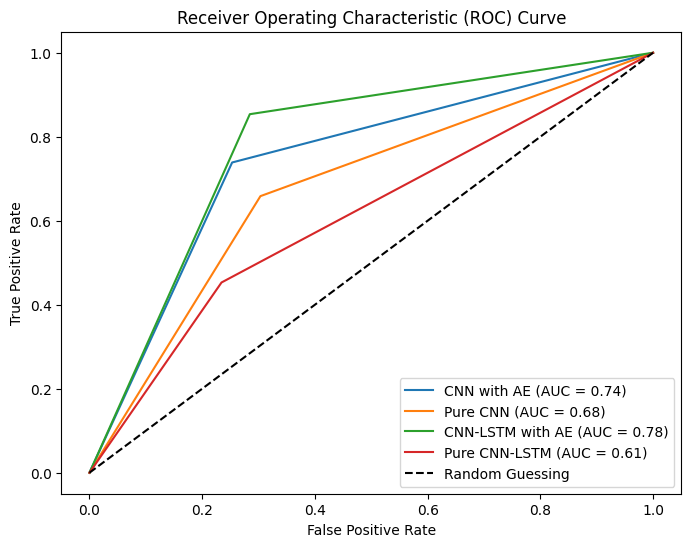

In [19]:
plt.figure(figsize=(8, 6))
for model_name, model in models.items():
    # Test the model
    correct = 0
    total = 0
    total_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Send inputs and labels to the device (GPU if available)
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            output = model(inputs)
            loss = criterion(output, labels)
            
            total_loss += loss.item()
            
            # Get predictions and probabilities
            _, predicted = torch.max(output, 1)
            
            # Update counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store predictions, labels, and probabilities for further metrics
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate AUC and plot ROC curve
    auc_score = roc_auc_score(all_labels, all_preds)
    fpr, tpr, _ = roc_curve(all_labels, all_preds)

    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()